In [94]:
import torch
import torchvision
from torchvision.datasets import CIFAR10
import matplotlib.pyplot as plt

In [95]:
# device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

In [96]:
train_data = CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor(),
    target_transform=None
)

test_data = CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor(),
    target_transform=None
)

Files already downloaded and verified
Files already downloaded and verified


In [97]:
len(train_data), len(test_data)

(50000, 10000)

In [98]:
class_names = train_data.classes
class_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

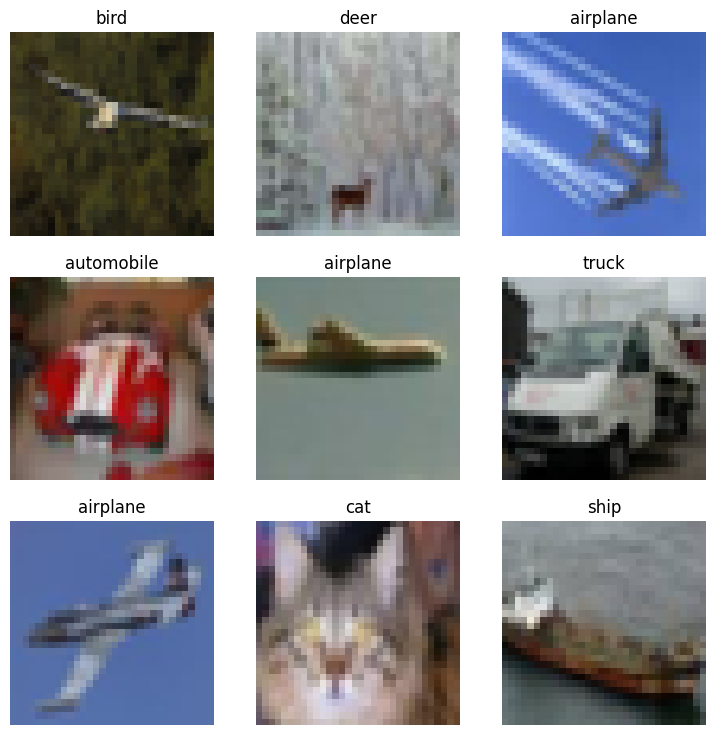

In [99]:
fig = plt.figure(figsize=(9, 9))
rows, cols = 3, 3

for i in range(1, rows*cols+1):
  random_idx = torch.randint(0, len(train_data), size=[1]).item()
  image, label = train_data[random_idx]
  fig.add_subplot(rows, cols, i)
  plt.imshow(image.permute(1, 2, 0))
  plt.title(class_names[label])
  plt.axis(False)

In [100]:
# Turn train and test data to dataloaders
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_dataloader = DataLoader(
    dataset=train_data,
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_dataloader = DataLoader(
    dataset=test_data,
    batch_size=BATCH_SIZE,
    shuffle=True
)

In [101]:
len(train_dataloader), len(test_dataloader)

(1563, 313)

In [102]:
from torch import nn
class TinyVGGModel(nn.Module):
  def __init__(self, input_shape, hidden_units, output_shape):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(
            in_channels=input_shape,
            out_channels=hidden_units,
            kernel_size=3,
            stride=1,
            padding=0
        ),
        nn.ReLU(),
        nn.Conv2d(
            in_channels=hidden_units,
            out_channels=hidden_units,
            kernel_size=3,
            stride=1,
            padding=0
        ),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=3)
    )

    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(
            in_channels=hidden_units,
            out_channels=hidden_units,
            kernel_size=3,
            stride=1,
            padding=0
        ),
        nn.ReLU(),
        nn.Conv2d(
            in_channels=hidden_units,
            out_channels=hidden_units,
            kernel_size=3,
            stride=1,
            padding=0
        ),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=3)
    )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(
            in_features=hidden_units,
            out_features=output_shape
        )
    )

  def forward(self, x):
    x = self.conv_block_1(x)
    x = self.conv_block_2(x)
    x = self.classifier(x)

    return x



In [103]:
model = TinyVGGModel(
    input_shape=3,
    hidden_units=8,
    output_shape=len(class_names)
).to(device)

model

TinyVGGModel(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=8, out_features=10, bias=True)
  )
)

In [104]:
# import helper function
import requests
from pathlib import Path

if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download...")

else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

helper_functions.py already exists, skipping download...


In [105]:
# import loss function, acc function and optimizer
from helper_functions import accuracy_fn

LEARNING_RATE = 0.1

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=LEARNING_RATE)

In [106]:
#!pip -q install torchmetrics

In [107]:
from torchmetrics import Accuracy
accuracy_fn = Accuracy(task="multiclass", num_classes=len(class_names)).to(device)

In [108]:
# calculate the total training time
from timeit import default_timer as timer

def print_train_time(start, end, device):
  total = end - start
  print(f"Total time on {device}: {total:.3f} seconds")
  return total

In [109]:
# training step function
def train_step(
    model,dataloader,loss_fn,
    accuracy_fn,optimizer,device):

  loss, acc = 0, 0

  model.train()
  for batch, (X, y) in enumerate(dataloader):
    # Put data to target device
    X, y = X.to(device), y.to(device)

    # 1. Forward pass
    y_pred = model(X)

    # 2. Calculate the loss
    loss += loss_fn(y_pred, y)
    acc += accuracy_fn(y_pred, y.int())

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss Backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    # print out what's happenin
    if batch % 500 == 0:
      print(f"Train loss: {loss:.5f} | Train acc: {acc:.2f}%")

  # Divide total train loss by length of train dataloader
  loss /= len(dataloader)
  acc /= len(dataloader)
  print(f"Train loss: {loss:.5f} | Train acc: {acc:.2f}%")


In [110]:
# test step function
def test_step(
    model, dataloader, loss_fn,
    accuracy_fn, device):
  loss, acc = 0, 0

  model.eval()

  with torch.inference_mode():
    for X, y in dataloader:
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      test_pred = model(X)

      # 2. Calculate the loss
      loss += loss_fn(test_pred, y)
      acc += accuracy_fn(test_pred, y.int())

  # Divide total test loss by length of test dataloader
  loss /= len(dataloader)
  acc /= len(dataloader)
  print(f"Test loss: {loss:.5f} | Test acc: {acc:.2f}%")



In [111]:
# Start training!

from tqdm.auto import tqdm

start_train_time = timer()

epochs = 5

for epoch in tqdm(range(epochs)):
  train_step(
      model, train_dataloader, loss_fn,
      accuracy_fn, optimizer, device
  )

  test_step(
      model, test_dataloader, loss_fn,
      accuracy_fn, device
  )

end_train_time = timer()
train_time = print_train_time(
    start_train_time,
    end_train_time,
    device
)



  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 2.28653 | Train acc: 0.09%


RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.